# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
Williams et al. (2014) suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by Testud et al. (2001).

Williams et al. (2014) analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in Williams et al. (2014) which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, Williams et al. (2014) determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty (**S**$_a$) form the mean and the covariance of the data set, respectively. 

# Installation 
**You can skip the installation if you execute this online on binder**

In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.18.1, Matplotlib 3.0.3, Scipy 1.2.1, Xarray 0.15.1, Pandas 1.0.3, Seaborn 0.9.0 and Uncertainties 3.0.3.

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA, Mech et al. 2020). Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 

# Preparation

We start with loading the required libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijklmopqrstuvwxyz'

/opt/anaconda3/envs/pyoe_examples/lib/python3.10/site-packages/pamtra2/libs/refractiveIndex/ice.py:55: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  warren_ice_table = pd.read_csv(
/opt/anaconda3/envs/pyoe_examples/lib/python3.10/site-packages/pamtra2/libs/singleScattering/ssrg.py:58: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  leinonen_table = pd.read_csv(module_path + '/ssrg_coeffs_jussiagg_simult.dat',
/opt/anaconda3/envs/pyoe_examples/lib/python3.10/abc.py:106: FutureWarning: xarray subclass customProfile should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines

## State vector

In order to load the required prior data set, we load the Huntsville data set of Williams et al. (2014) from a netCDF file using xarray:

In [3]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')[[
    'Dm', 'Nw', 'Smprime'
]]

and add logarithmic variables with

In [4]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 152kB 2009-12-13T04:24:00 ... 2011-0...
Data variables:
    Dm             (time) float64 152kB 1.117 1.003 1.014 ... 1.377 1.475 1.476
    Nw             (time) float64 152kB 2.328e+03 4.55e+03 ... 1.156e+03
    Smprime        (time) float64 152kB 0.3058 0.2524 0.2513 ... 0.3386 0.3318
    Nw_log10       (time) float64 152kB 3.367 3.658 4.037 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 152kB 0.04817 0.001143 ... 0.1689 0.1692
    Smprime_log10  (time) float64 152kB -0.5145 -0.598 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [5]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make quantile-quantile (QQ) plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. 

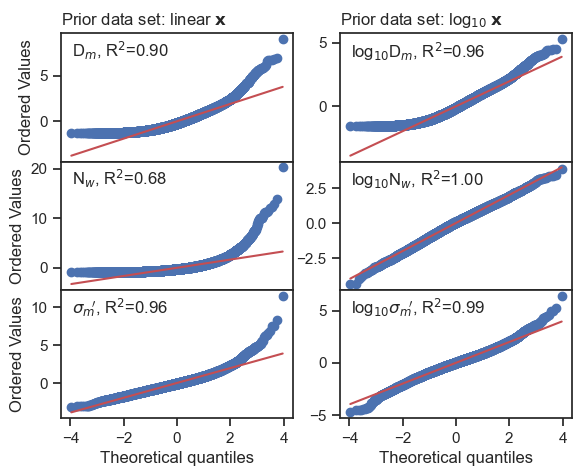

In [6]:
ncols = 2
fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)

sps = sps.reshape((3, ncols))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Smprime']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]
        data = (rainDat_training[x_var] - np.mean(
            rainDat_training[x_var])) / np.std(rainDat_training[x_var])
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)

        sps[kk, ii].set_title('')
        if kk == 0:
            sps[kk, ii].set_title(
                'Prior data set: %s $\mathbf{x}$' % (x_name),
                loc='left')

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s, R$^2$=%.2f' % (
                supporting_routines.niceKeys[x_var], r**2
                #, x_mean, x_std
            ),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)

        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.subplots_adjust(hspace=0)

The prior $\mathbf{x}_{a}$ and covariance **S**$_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

Dm                  1.461640
Nw               4054.575495
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Smprime_log10      -0.530466
dtype: float64


<Axes: >

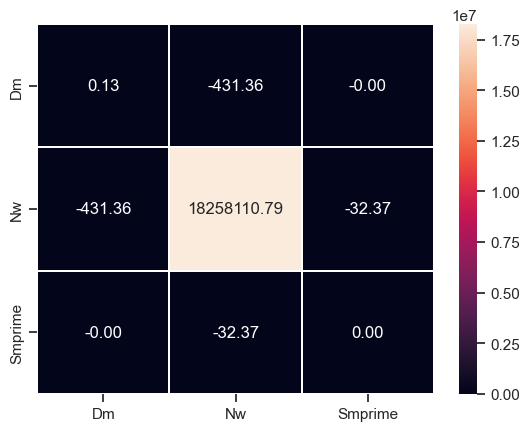

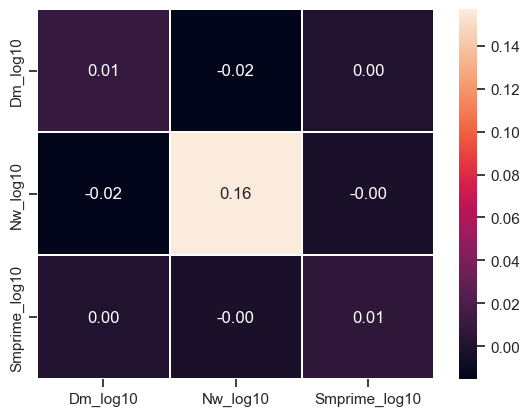

In [7]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm', 'Nw', 'Smprime']
    ].loc[
        ['Dm', 'Nw', 'Smprime']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ].loc[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. 

In [8]:
rainDat_training

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 18869)
Coordinates:
  * time           (time) datetime64[ns] 151kB 2011-02-25T06:46:00 ... 2011-0...
Data variables:
    Dm             (time) float64 151kB 1.72 1.138 1.201 ... 1.868 1.861 1.701
    Nw             (time) float64 151kB 2.81e+03 2.267e+03 ... 895.9 1.936e+03
    Smprime        (time) float64 151kB 0.344 0.3775 0.2275 ... 0.2762 0.358
    Nw_log10       (time) float64 151kB 3.449 3.355 3.729 ... 3.321 2.952 3.287
    Dm_log10       (time) float64 151kB 0.2354 0.05624 0.0794 ... 0.2697 0.2306
    Smprime_log10  (time) float64 151kB -0.4635 -0.4231 ... -0.5588 -0.4462

## Measurement space

The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 13.6 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  **S**$_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

In [ ]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Forward operator
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [ ]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])


The message about `relativePermittivityIce` can be ignored. After this, the forward operator can be run with `supporting_routines.forwardPamtra`.  In short, the forward operator accepts $\mathbf{x}$ as an input argument and returns $\mathbf{y}$. In addition, `pam2Prepared` (prepared above) and the list of $\mathbf{y}$ elements to be returned needs to be provided. See `libs/supporting_routines.py` for details.

# Example retrieval

First, we need names for the elements of $\mathbf{x}$  and $\mathbf{y}$ 

In [ ]:
x_vars = ['Dm', 'Nw', 'Smprime']
y_vars = ["Ze_13.6", "MDV_13.6"]

Additional  variables required for the forward operator

In [ ]:
forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

We use the 51st profile from the test data set as $\mathbf{x}_{truth}$

In [ ]:
tt = 51
x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

For simplicity, we use synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance by comparing $\mathbf{x}_{op}$ to $\mathbf{x}_{truth}$. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [ ]:
y_obs = supporting_routines.forwardPamtra(
    x_truth,
    **forwardKwArgs,
)
y_obs

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe` 

In [ ]:
# create optimal estimation object
oe = pyOE.optimalEstimation(
    x_vars,  # state variable names
    x_ap[x_vars],  # a priori
    S_a[x_vars].loc[x_vars],  # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs,  # observations
    S_y[y_vars].loc[y_vars],  # observation uncertainty
    supporting_routines.forwardPamtra,  # forward Operator
    forwardKwArgs=forwardKwArgs,  # additonal function arguments
)

We store the true profile in the `oe` object. This is just for convenience, it is not
used by the retrieval.

In [ ]:
oe.x_truth = x_truth

We run the retrieval with max. 10 iterations.

In [ ]:
converged = oe.doRetrieval(maxIter=10)

It converges after 2 iterations. 1.91 degrees of freedom for signal $d$ (the number of independent information pieces) are retrieved which is shows the good performance of the retrieval given that the maximum $d$ value is 2 because $\mathbf{y}$ consists of 2 measurements. 

After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with

In [ ]:
print(oe.x_op)
print(oe.S_op)

pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are not mixed up.

For convenience, the 1 $\sigma$ uncertainties derived from **S**$_{op}$ are also available

In [ ]:
print(oe.x_op_err)

$d$ is available as a total as well as per $\mathbf{x}$ variable

In [ ]:
print('total', oe.dgf)
print(oe.dgf_x)

We recommend to apply various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior **S**$_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior **S**$_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior **S**$_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 



In [ ]:
print(oe.chiSquareTest()[0])

Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [ ]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(
    significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

The fact that this test fails indicates already that the retrieval with linear $\mathbf{x}$ variables does not work properly (see below).

When running several retrievals, we recommend using the `oe.summarize` function which summarizes all retrieval results in an Xarray Dataset (which is structured similar to a netCDF file):

In [ ]:
oe.summarize(returnXarray=True)

# Run retrieval

After we presented the retrieval step-by-step, we integrate everything into a loop to apply the retrieval to all 100 profiles. 

The results are saved in dictionaries:

In [ ]:
resultsOE = {}
failed = {}

To compare performance, we run the retrieval in two configurations:

1. linear state variables (see the step-by-step example above)
2. logarithmic state variables


In [ ]:
#     name, [X_variables],
x_names = dict([
    ('Linear', ['Dm', 'Nw', 'Smprime']),
    ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
])

In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to experiment  with different configurations. 


In [ ]:
#     name, [Y_variables],
y_names = dict([
    ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])

In [ ]:
%%time
for x_name, y_name in (
    (
        'Linear',
        'ZW',
    ),
    ('log$_{10}$', 'ZW'),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s %s' % (x_name, y_name)] = []
    failed['%s %s' % (x_name, y_name)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name)
    print('#' * 80)
 
    #     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars],  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print(
                    'RMS log',
                    np.sqrt(
                        np.mean(
                            ((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values, oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS',
                      np.sqrt(np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values, oe.x_op_err.values))

            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            summary['time'] = rainDat_test[x_vars].time[tt]

            resultsOE['%s %s' % (x_name, y_name)].append(summary)
        else:
            failed['%s %s' % (x_name, y_name)].append(tt)

    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s %s' % (x_name, y_name)] = xr.concat(
        resultsOE['%s %s' % (x_name, y_name)], dim='time')

# Analyze results


## Compare retrieval quality

Here we compare the retrieval quality by comparing the number of profiles that converged, passed the $\chi^2$-tests, and the linearity test:

In [ ]:
fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6, 4))

for kk, key in enumerate(resultsOE.keys()):

    converged = len(resultsOE[key].time)
    passedLinearity = (resultsOE[key].trueLinearityChi2 <
                       resultsOE[key].trueLinearityChi2Critical).sum().values
    passedChi2 = (resultsOE[key].chi2value <
                  resultsOE[key].chi2critical).all('chi2test').sum().values

    sps[0].bar(kk, converged, label=key, width=0.98)
    sps[1].bar(kk, passedChi2, label=key, width=0.98)
    sps[2].bar(kk, passedLinearity, label=key, width=0.98)

    sps[0].text(
        kk, converged + .25, str(converged), horizontalalignment='center')
    sps[1].text(
        kk, passedChi2 + .25, str(passedChi2), horizontalalignment='center')
    sps[2].text(
        kk,
        passedLinearity + .25,
        str(passedLinearity),
        horizontalalignment='center')

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear tests')
    sps[1].set_xlabel('passed all $\chi^2$ tests')

    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0, 110)
    sps[0].legend(loc='lower center')

    for ii in range(3):
        sps[ii].text(
            0.05,
            0.97,
            '%s)' % (abc[ii]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[ii].transAxes)

Independently how performance is measured, the version with the logarithmic $\mathbf{x}$ variables performs better. It should be noted that applying a $\chi^2$ test with 5% confidence interval to a larger number of retrievals means that 5% of the profiles do not pass the test even though they are fine.

## Compare retrieval error distributions

Similar to the prior, we also compare the distributions of relative retrieval errors defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathsf{S}_y)}}
   \end{equation}

In theory, the relative retrieval errors should follow a normal distribution with mean 0 and standard deviation 1. 

In [ ]:
ncols = len(resultsOE.keys())
fig, sps = plt.subplots(
    figsize=(3.33 * ncols, 5), nrows=len(x_vars), ncols=ncols, sharex=True)

sps = sps.reshape((len(x_vars), ncols))

jj = 0

for yy, key in enumerate(resultsOE.keys()):

    for kk in range(3):

        x_var = resultsOE[key].x_vars.values[kk]
        thisOe = resultsOE[key].isel(x_vars=kk)
        passedChiTests = (thisOe.chi2value <=
                          thisOe.chi2critical).all('chi2test')
        thisOe = thisOe.where(passedChiTests).dropna('time')
        x_err = ((thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(key, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, yy], fit=True, rvalue=False)

        sps[kk, yy].set_title('')
        if kk == 0:
            sps[kk, yy].set_title(
                'Posterior data set: %s $\mathbf{x}$' %
                (key.split(' ')[0]),
                loc='left')

        sps[kk, yy].text(
            0.95,
            0.05,
            '%s, R$^2$=%.2f\nmean=%.2f, std=%.2f' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, yy].transAxes)

        if kk < 2:
            sps[kk, yy].set_xlabel("")
        sps[kk, yy].set_ylabel("")

        jj += 1

fig.subplots_adjust(hspace=0)

With one exception, mean and standard deviation are closer to 0 and 1, respectively, for the logarithmic retrieval. In other words, non-normally distributed state variables lead to non-normally distributed retrieval error distributions. In this case, the retrieval uncertainty is not correctly described with **S**$_{op}$. 

## Compare retrieval information content

Here, we compare the information content of the two retrieval versions. For this we use the optimal to prior uncertainty ratio (defined as sqrt[diag(**S**$_{op}$)/diag(**S**$_a$)]) and the individual *d* for all profiles

In [ ]:

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,3))
positions = np.array([0,2,4])
                     


for yy, key in enumerate(resultsOE.keys()):

    thisOE = resultsOE[key].where((resultsOE[key].chi2value < resultsOE[key].chi2critical).all('chi2test'))
    
    dat = (thisOE['x_op_err']/thisOE['x_a_err']).to_pandas().dropna() * 100
    try: #Different Matplotlib versions handle this differently
        ax1.violinplot(dat, positions = positions+yy, showmedians=True)
    except ValueError:
        ax1.violinplot(dat.T, positions = positions+yy, showmedians=True)

    dat = (thisOE['dgf_x']).to_pandas().dropna()
    try: #Different Matplotlib versions handle this differently
        ax2.violinplot(dat, positions = positions+yy, showmedians=True)
    except ValueError:
        ax2.violinplot(dat.T, positions = positions+yy, showmedians=True)

    
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt].replace('log','\nlog'))
ax2.set_xticks(range(6)) 
ax2.set_xticklabels(labels) 
ax1.set_xticks(range(6)) 
ax1.set_xticklabels(labels) 

ax1.set_ylabel('optimal to prior\nuncertainty ratio [%]')
ax2.set_ylabel('degrees of freedom\nfor signal [-]')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='C0', lw=4),
                matplotlib.lines.Line2D([0], [0], color='C1', lw=4),
               ]

ax1.legend(custom_lines, ['linear', 'log$_{10}$'], loc='lower right')
ax1.text(0.03, 0.97, 'a)', horizontalalignment='left', verticalalignment='top', transform = ax1.transAxes)
ax2.text(0.03, 0.03, 'b)', horizontalalignment='left', verticalalignment='bottom', transform = ax2.transAxes)

plt.tight_layout()
plt.savefig('Figure4.png', dpi=200)
plt.savefig('Figure4.pdf')


Interestingly, the median values of the optimal to prior uncertainty ratio distribution are lower for the linear state variables indicating that the linear retrieval version is in general underestimating retrieval uncertainties. At the same time, *d* can be greatly overestimated for individual profiles. 

# References

Mech, M., M. Maahn, S. Kneifel, D. Ori, E. Orlandi, P. Kollias, V. Schemann, and S. Crewell, 2020: PAMTRA 1.0: A Passive and Active Microwave radiative TRAnsfer tool for simulating radiometer and radar measurements of the cloudy atmosphere. Geoscientific Model Development Discussions, 1–34, doi:https://doi.org/10.5194/gmd-2019-356.

Testud, J., S. Oury, R. A. Black, P. Amayenc, and X. Dou, 2001: The concept of normalized distribution to describe raindrop spectra: A tool for cloud physics and cloud remote sensing. *J. Appl. Meteorol.*, 40, 1118–1140, [https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2](https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2).

Williams, C. R., V. N. Bringi, L. D. Carey, V. Chandrasekar, P. N. Gatlin, Z. S. Haddad, R. Meneghini, S. Joseph Munchak, S. W. Nesbitt, W. A. Petersen, S. Tanelli, A. Tokay, A. Wilson, and D. B. Wolff, 2014: Describing the Shape of Raindrop Size Distributions Using Uncorrelated Raindrop Mass Spectrum Parameters. *J. Appl. Meteor. Climatol.*, 53, 1282–1296, https://doi.org/10.1175/JAMC-D-13-076.1.


